# Visualizing NURBS DIC Results from Synthetic Testing
## Sam Potter
## Current: 3/6/19

## Path and Imports

In [1]:
import sys
import os

sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\BitBucket\dic',
                 'C:/Users/potterst1/Desktop/Repositories/BitBucket/dic'])
sys.path.extend(['/workspace/stpotter/git/bitbucket/dic'])
from dic import visualize
import cv2
from matplotlib import pyplot as plt
import numpy as np
from geomdl import BSpline as bs
from geomdl import utilities as gutil
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats

## Magics

In [2]:
%matplotlib inline

## Read in results data from text files

In [3]:
# Define a function for ease of use. Brittle and expects a certain format, but okay for now

def results_open(fname):
    
    f = open(fname, 'r')
    lines = f.readlines()
    lines = lines[3:]
    data = np.zeros((len(lines), 4))
    for i in range(0, len(data)):
        entry = list(map(float, lines[i].split()))
        data[i, :] = np.array(entry)
    return data
        
# Get synthetic
fname = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\scripts\\3Steps\\stretchx\\01synthetic.txt'
synth01 = results_open(fname)

fname = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\scripts\\3Steps\\stretchx\\12synthetic.txt'
synth12 = results_open(fname)

# Get minimization
fname = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\scripts\\3Steps\\stretchx\\01results.txt'
min01 = results_open(fname)

fname = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\scripts\\3Steps\\stretchx\\12results.txt'
min12 = results_open(fname)

## Visualize Applied Synthetic Displacement, Deformation

### Total Displacement

In [4]:
# Load image
imgname = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\data\\DIC_S_cropped_gray_pad_0.tiff'
image = cv2.imread(imgname, -1)

In [5]:
# Set total deformation
synth_total_disp = synth01[:, 2:] + synth12[:, 2:]
min_total_disp = min01[:, 2:] + min12[:, 2:]

# Set number of control points
num_ctrlpts = np.sqrt(len(synth_total_disp)).astype('int')

# Set row and col max/min
rowmin_index = int(synth01[:, 1].min())
rowmax_index = int(synth01[:, 1].max())
colmin_index = int(synth01[:, 0].min())
colmax_index = int(synth01[:, 0].max())

In [10]:
# Set up reference mesh surface for synthetic deformation
# Coords
coords = synth01[:, :2]

# Surface
ref_surf = bs.Surface()

ref_surf.degree_u = 3
ref_surf.degree_v = 3

num_ctrlpts = np.sqrt(len(coords)).astype('int')

ref_surf.set_ctrlpts(coords.tolist(), num_ctrlpts, num_ctrlpts)

ref_surf.knotvector_u = gutil.generate_knot_vector(ref_surf.degree_u, num_ctrlpts)
ref_surf.knotvector_v = gutil.generate_knot_vector(ref_surf.degree_v, num_ctrlpts)

ref_surf.delta = 0.01

In [6]:
# Setup synthetic displacement surface
synth_disp_surf = bs.Surface()

synth_disp_surf.degree_u = 3
synth_disp_surf.degree_v = 3

synth_disp_surf.set_ctrlpts(synth_total_disp.tolist(), num_ctrlpts, num_ctrlpts)

synth_disp_surf.knotvector_u = gutil.generate_knot_vector(synth_disp_surf.degree_u, num_ctrlpts)
synth_disp_surf.knotvector_v = gutil.generate_knot_vector(synth_disp_surf.degree_v, num_ctrlpts)

synth_disp_surf.delta = 0.01

In [7]:
# Fill synthetic
U_synth = np.zeros(image.shape) * np.nan
V_synth = np.zeros(image.shape) * np.nan

for i in range(rowmin_index, rowmax_index):
    for j in range(colmin_index, colmax_index):
        u_val = (j - colmin_index) / (colmax_index - colmin_index)
        v_val = (i - rowmin_index) / (rowmax_index - rowmin_index)
        disp_synth = np.array(synth_disp_surf.surfpt(u_val, v_val))
        U_synth[i, j] = disp_synth[0]
        V_synth[i, j] = disp_synth[1]

Text(0.5, 1.0, 'Synthetic Y Displacement (Pixels)')

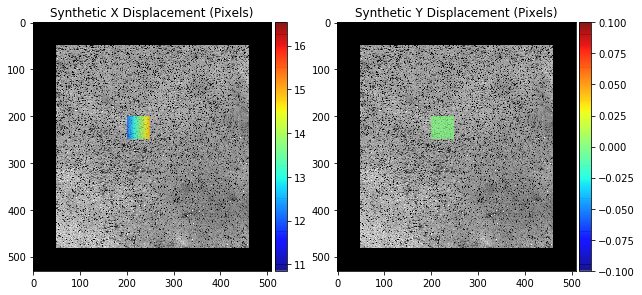

In [14]:
# Display
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))
im0 = ax0.imshow(image, cmap='gray')
Uim = ax0.imshow(U_synth, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(Uim, cax=cax0)
Umin = 0.9 * np.nanmin(U_synth)
Umax = 1.1 * np.nanmax(U_synth)
Uim.set_clim(Umin, Umax)
ax0.set_title('Synthetic X Displacement (Pixels)')

im1 = ax1.imshow(image, cmap='gray')
Vim = ax1.imshow(V_synth, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(Vim, cax=cax1)
Vmin = 0.9 * np.nanmin(V_synth)
Vmax = 0.9 * np.nanmax(V_synth)
Vim.set_clim(Vmin, Vmax)
ax1.set_title('Synthetic Y Displacement (Pixels)')

### Total Deformation

In [ ]:
# Synthetic Deformation arrays
F11_synth = np.zeros(image.shape) * np.nan
F12_synth = np.zeros(image.shape) * np.nan
F21_synth = np.zeros(image.shape) * np.nan
F22_synth = np.zeros(image.shape) * np.nan

for i in range(rowmin_index, rowmax_index):
    for j in range(colmin_index, colmax_index):
        u_val = (j - colmin_index) / (colmax_index - colmin_index)
        v_val = (i - rowmin_index) / (rowmax_index - rowmin_index)
        F_val= visualize.def_grad(ref_surf, u_val, v_val, synth_total_disp)
        F11_synth[i, j] = F_val[0, 0]
        F12_synth[i, j] = F_val[0, 1]
        F21_synth[i, j] = F_val[1, 0]
        F22_synth[i, j] = F_val[1, 1]

Text(0.5, 1.0, 'F22')

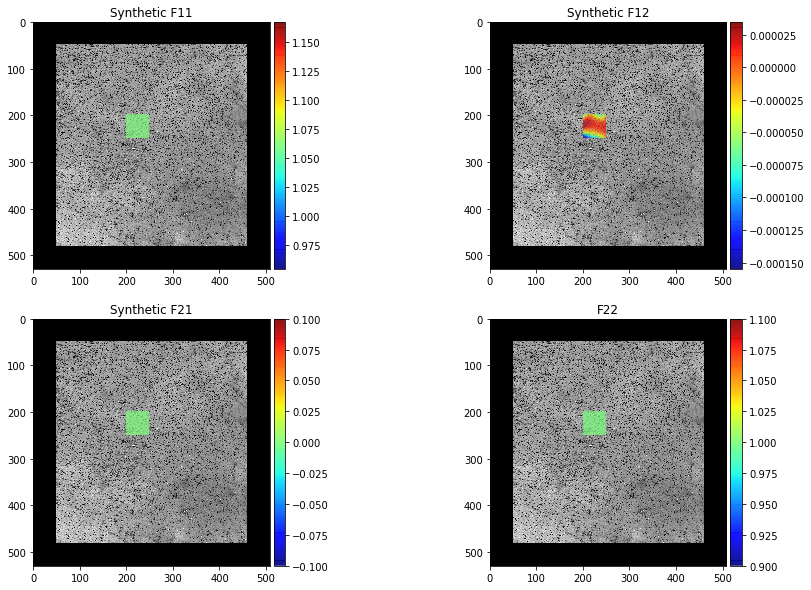

In [16]:
# Display
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15, 10))

im0 = ax0.imshow(image, cmap='gray')
F11im = ax0.imshow(F11_synth, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax0)
cax0 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F11im, cax=cax0)
F11min = 0.9 * np.nanmin(F11_synth)
F11max = 1.1 * np.nanmax(F11_synth)
F11im.set_clim(F11min, F11max)
ax0.set_title('Synthetic F11')

im1 = ax1.imshow(image, cmap='gray')
F12im = ax1.imshow(F12_synth, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F12im, cax=cax1)
F12min = 0.9 * np.nanmin(F12_synth)
F12max = 1.1 * np.nanmax(F12_synth)
F12im.set_clim(F12min, F12max)
ax1.set_title('Synthetic F12')

im2 = ax2.imshow(image, cmap='gray')
F21im = ax2.imshow(F21_synth, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F21im, cax=cax2)
F21min = 0.9 * np.nanmin(F21_synth)
F21max = 1.1 * np.nanmax(F21_synth)
F21im.set_clim(F21min, F21max)
ax2.set_title('Synthetic F21')

im3 = ax3.imshow(image, cmap='gray')
F22im = ax3.imshow(F22_synth, cmap='jet', alpha=0.7)
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(F22im, cax=cax3)
F22min = 0.9 * np.nanmin(F22_synth)
F22max = 1.1 * np.nanmax(F22_synth)
F22im.set_clim(F22min, F22max)
ax3.set_title('F22')

In [20]:
F = np.array([[1.01, 0],[0, 1]])
applied_F = F @ F @ F
synth_F = visualize.def_grad(ref_surf, u_val, v_val, synth_total_disp)
print('Applied F:')
print(applied_F)
print('Synthetic F:')
print(synth_F)

Applied F:
[[1.030301 0.      ]
 [0.       1.      ]]
Synthetic F:
[[ 1.06066207e+00 -1.09589600e-05]
 [ 0.00000000e+00  1.00000000e+00]]


## Visualize Minimization Result Displacement, Deformation

## Compute Differences between Applied and Minimized Results

## Visualize Differences betwteen Applied and Minimized Results 

## Compute Statistics on Differences between Applied and Minimized Results